In [13]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

import pyspark.sql.functions as fn
import pyspark.sql.types as typ

In [14]:
spark = SparkSession.builder.appName('Explore data').getOrCreate()

# 1. Duplicates:

In [15]:
df = spark.createDataFrame([
    (1, 144.5, 5.9, 33, 'M'),
    (2, 167.2, 5.4, 45, 'M'),
    (3, 124.1, 5.2, 23, 'F'),
    (4, 144.5, 5.9, 33, 'M'),
    (5, 133.2, 5.7, 54, 'F'),
    (3, 124.1, 5.2, 23, 'F'),
    (5, 129.2, 5.3, 42, 'M'),
    ], ['id', 'weight', 'height', 'age', 'gender'])

In [16]:
print('Row count: %d'%(df.count()) )
print('Count distinct row: %d'%(df.distinct().count()))

Row count: 7
Count distinct row: 6


In [17]:
# drop duplicate
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



In [18]:
print('Count of ids:', df.count())
print('Count of distinct ids: ', df.select(*[c for c in df.columns if c!='id']).distinct().count())

Count of ids: 6
Count of distinct ids:  5


In [19]:
# drop duplicate of subset
df = df.dropDuplicates(subset=[c for c in df.columns if c!='id'])
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



In [20]:
# see if there are duplicated ids
df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('countDistinct')
).show()

+-----+-------------+
|count|countDistinct|
+-----+-------------+
|    5|            4|
+-----+-------------+



In [21]:
# create a new id column of monotonical increasing
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



# 2.Missing observation:
- You can drop it
    - If the most part of missing value comes from 1 feature, better drop that column
- Fill the null
    - If data is discrete boolean, change it to categorical and add the third category: Missing
    - If data is categorical, add Missing cate as well
- If dealing with ordinal or numerical data, replace by some such as: mean, median, some other predefined values (up to the data distribution)
        

In [22]:
df_miss = spark.createDataFrame([
    (1, 143.5, 5.6, 28,
    'M', 100000),
    (2, 167.2, 5.4, 45,
    'M', None),
    (3, None , 5.2, None, None, None),
    (4, 144.5, 5.9, 33,
    'M', None),
    (5, 133.2, 5.7, 54,
    'F', None),
    (6, 124.1, 5.2, None, 'F', None),
    (7, 129.2, 5.3, 42,
    'M', 76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

df_miss.show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  1| 143.5|   5.6|  28|     M|100000|
|  2| 167.2|   5.4|  45|     M|  null|
|  3|  null|   5.2|null|  null|  null|
|  4| 144.5|   5.9|  33|     M|  null|
|  5| 133.2|   5.7|  54|     F|  null|
|  6| 124.1|   5.2|null|     F|  null|
|  7| 129.2|   5.3|  42|     M| 76000|
+---+------+------+----+------+------+



In [23]:
df_miss.rdd.map(
        lambda row: (row['id'], sum ([c==None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

In [24]:
df_miss.agg(
    *[(1 - fn.count(c)/fn.count('*')).alias(c+'_missing') for c in df_miss.columns]
).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



In [25]:
df_miss_no_income=df_miss.drop('income')
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [26]:
# dropna with thresh (param define min None column whether a row should be drop)
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [27]:
# fill na

# get means over each numerical feature, convert to dictionary
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

# add missing value of gender to dict
means['gender'] = 'missing'

print(means)

df_miss_no_income.fillna(value=means).show()

{'id': 4.0, 'weight': 140.28333333333333, 'height': 5.4714285714285706, 'age': 40.399999999999999, 'gender': 'missing'}
+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



# 3. Outliers:
- Outliers are those observations that deviate significantly from the
distribution of the rest of your sample.

In [28]:
df_outliers = spark.createDataFrame([
    (1, 143.5, 5.3, 28),
    (2, 154.2, 5.5, 45),
    (3, 342.3, 5.1, 99),
    (4, 144.5, 5.5, 33),
    (5, 133.2, 5.4, 54),
    (6, 124.1, 5.1, 21),
    (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

df_outliers.show()

+---+------+------+---+
| id|weight|height|age|
+---+------+------+---+
|  1| 143.5|   5.3| 28|
|  2| 154.2|   5.5| 45|
|  3| 342.3|   5.1| 99|
|  4| 144.5|   5.5| 33|
|  5| 133.2|   5.4| 54|
|  6| 124.1|   5.1| 21|
|  7| 129.2|   5.3| 42|
+---+------+------+---+



In [29]:
cols = ['weight', 'height', 'age']
bounds = {}
for col in cols:
    quantiles = df_outliers.approxQuantile(
        col, [0.25, 0.75], 0.05
    )
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [
        quantiles[0] - 1.5 * IQR,
        quantiles[1] + 1.5 * IQR
    ]
    
bounds

{'weight': [91.69999999999999, 191.7],
 'height': [4.499999999999999, 6.1000000000000005],
 'age': [-11.0, 93.0]}

In [30]:
outliers = df_outliers.select(*['id'] + [
(
(fn.col(c) < bounds[c][0]) |
(df_outliers[c] > bounds[c][1])
).alias(c + '_o') for c in cols
    ])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



# 4. CCFraud data:

In [57]:
## a. Data types of columns

In [42]:
fraud = spark.read.csv('ccFraud.csv', header=True)

In [43]:
cols = fraud.columns

In [44]:
# cast all features to integer
fraud_df = fraud
for c in cols:
    fraud_df = fraud_df.withColumn(c, fraud_df[c].cast('integer'))

In [52]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [46]:
# imbalanced distrubution of gender
fraud_df.groupBy('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



In [ ]:
## b. Column describe:

In [47]:
# some statistic trait of numerical columns:
numeric_cols = ['balance', 'numTrans', 'numIntlTrans']
desc = fraud_df.describe(numeric_cols)
desc.show()

+-------+------------------+-----------------+-----------------+
|summary|           balance|         numTrans|     numIntlTrans|
+-------+------------------+-----------------+-----------------+
|  count|          10000000|         10000000|         10000000|
|   mean|      4109.9199193|       28.9351871|        4.0471899|
| stddev|3996.8473097372575|26.55378102452298|8.602970115863945|
|    min|                 0|                0|                0|
|    max|             41485|              100|               60|
+-------+------------------+-----------------+-----------------+



In [56]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552993377|
+------------------+



In [ ]:
## c. Correlation:

In [59]:
fraud_df.show(5)

+------+------+-----+----------+-------+--------+------------+----------+---------+
|custID|gender|state|cardholder|balance|numTrans|numIntlTrans|creditLine|fraudRisk|
+------+------+-----+----------+-------+--------+------------+----------+---------+
|     1|     1|   35|         1|   3000|       4|          14|         2|        0|
|     2|     2|    2|         1|      0|       9|           0|        18|        0|
|     3|     2|    2|         1|      0|      27|           9|        16|        0|
|     4|     1|   15|         1|      0|      12|           0|         5|        0|
|     5|     1|   46|         1|      0|      11|          16|         7|        0|
+------+------+-----+----------+-------+--------+------------+----------+---------+
only showing top 5 rows



In [58]:
fraud_df.corr('balance', 'numTrans')

0.0004452314017265534

In [67]:
# build a full matrix of correlations:
corr = []
size = len(numeric_cols)
for i in range(size):
    corr.append([None]*size)
    for j in range(size):
        corr[i][j] = fraud_df.corr(numeric_cols[i], numeric_cols[j])
    
print(corr)

[[1.0, 0.0004452314017265534, 0.0002713991339817854], [0.00044523140172655364, 1.0, -0.0002805712819816621], [0.0002713991339817863, -0.00028057128198165945, 1.0]]


In [68]:
# 5. Visualization:

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [75]:
import bokeh
from bokeh.io import output_notebook

In [76]:
!pip install bokeh.charts

  Could not find a version that satisfies the requirement bokeh.charts (from versions: )
No matching distribution found for bokeh.charts
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [77]:
hists = fraud_df.select('balance').rdd.flatMap(
lambda row: row
).histogram(20)

In [78]:
hists

([0.0,
  2074.25,
  4148.5,
  6222.75,
  8297.0,
  10371.25,
  12445.5,
  14519.75,
  16594.0,
  18668.25,
  20742.5,
  22816.75,
  24891.0,
  26965.25,
  29039.5,
  31113.75,
  33188.0,
  35262.25,
  37336.5,
  39410.75,
  41485],
 [3640021,
  2258778,
  1718633,
  1035019,
  601524,
  343461,
  192766,
  104486,
  54517,
  27570,
  13117,
  5805,
  2650,
  1103,
  358,
  127,
  45,
  15,
  1,
  4])

Text(0.5,1,"Histogram of 'balance'")

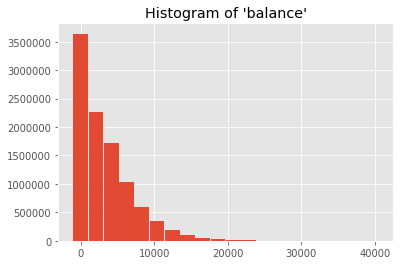

In [90]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}
plt.bar(data['bins'], data['freq'], width=2000)
plt.title('Histogram of \'balance\'')

In [96]:
data_sample = fraud_df.sampleBy('gender', {1: 0.0002, 2: 0.0002}).select(numeric_cols)
data_sample.show()

+-------+--------+------------+
|balance|numTrans|numIntlTrans|
+-------+--------+------------+
|   1755|       7|           0|
|   3000|      15|           8|
|   6927|       9|           0|
|   4000|      26|           0|
|    613|      27|           1|
|   3000|      38|           0|
|   4000|       5|           0|
|   2343|       9|           0|
|   3000|      25|           0|
|   7000|      11|           9|
|   8258|      16|           2|
|   7000|       4|           0|
|  18000|      11|           2|
|      0|      35|           0|
|      0|      21|           0|
|      0|      46|           0|
|   7000|      19|          27|
|  14279|      12|           3|
|   3000|       5|           7|
|   7000|      13|           0|
+-------+--------+------------+
only showing top 20 rows



In [103]:
data_multi = dict([
    (elem, data_sample.select(elem).rdd \
    .flatMap(lambda row: row).collect())
    for elem in numeric_cols
])



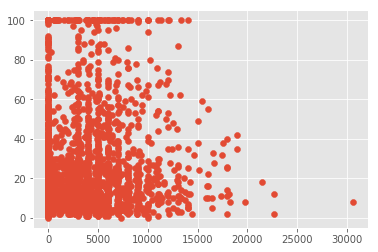

In [108]:
plt.scatter( x=data_multi['balance'], y=data_multi['numTrans'])